In [4]:
import polars as pl
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import faiss

In [5]:
df = pl.read_parquet('/kaggle/input/news-sentiment-aware-stock-market-forecasting/russian_news_embeddings.parquet')
embeddings = np.array(df['embedding'].to_list())
embeddings = embeddings.astype(np.float32)
faiss.normalize_L2(embeddings)

In [10]:
def create_graph_visualization(coords, embeddings, title, threshold=0.8):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(embeddings)
    
    k = 10
    similarities, indices = index.search(embeddings, k)
    
    G = nx.Graph()
    
    for i in range(len(coords)):
        G.add_node(i, pos=(coords[i, 0], coords[i, 1]))
    
    for i in range(len(embeddings)):
        for j, sim in zip(indices[i], similarities[i]):
            if i != j and sim > threshold:  # Avoid self-loops
                G.add_edge(i, j, weight=float(sim))
    
    plt.figure(figsize=(12, 12))
    pos = nx.get_node_attributes(G, 'pos')
    
    nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.6)
    
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.2)
    
    plt.title(f'Text Embeddings Threshold (cosine similarity) Graph Visualization - {title}')
    plt.axis('off')
    plt.show()

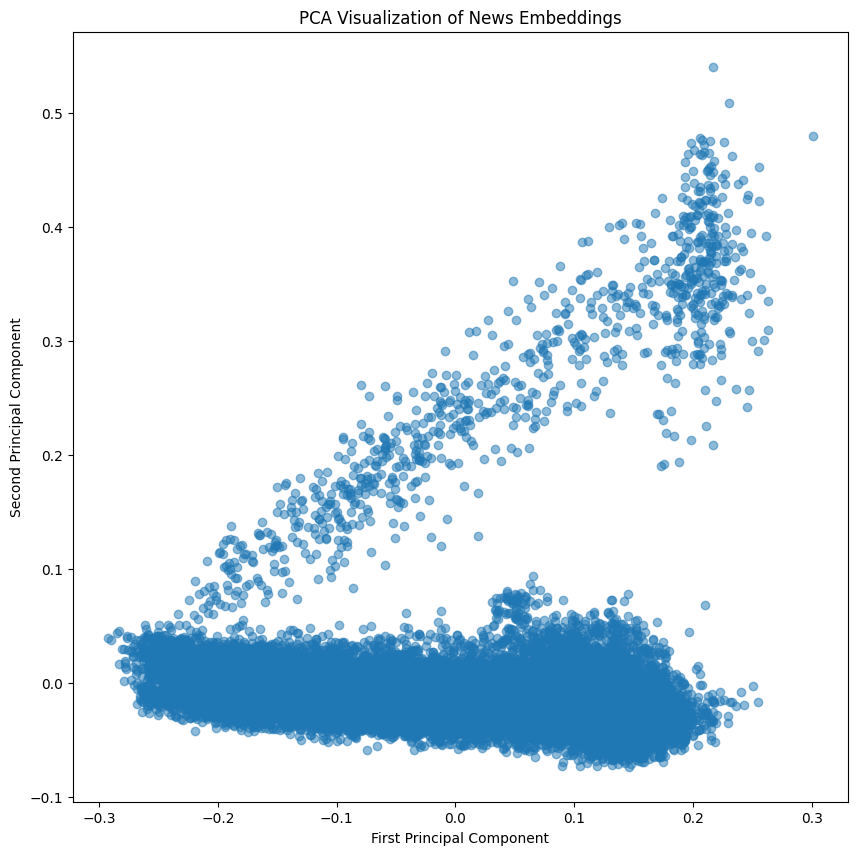

In [7]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.5)
plt.title('PCA Visualization of News Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

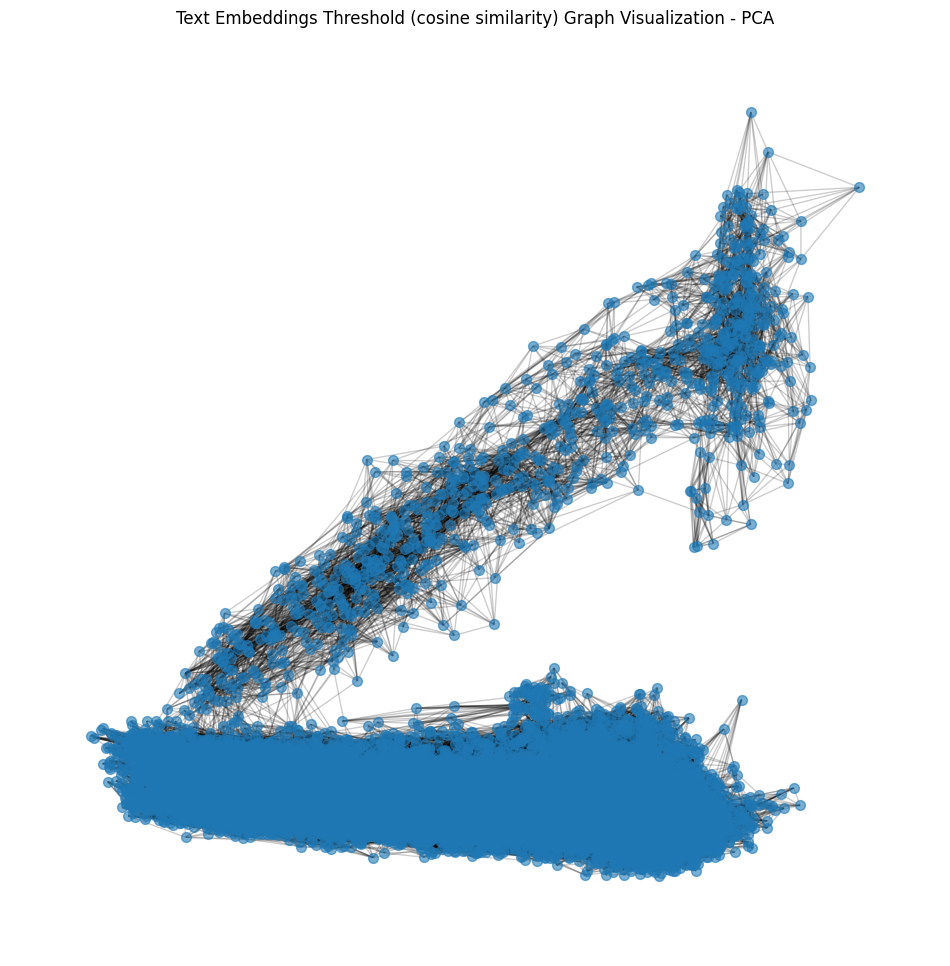

In [11]:
create_graph_visualization(pca_coords, embeddings, 'PCA')

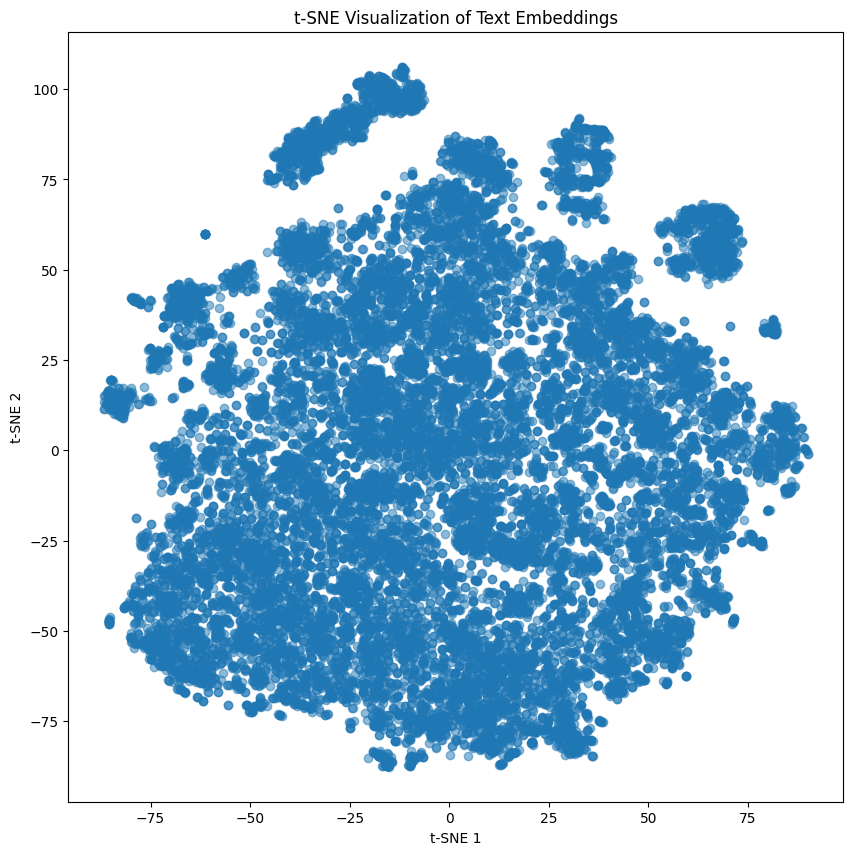

In [8]:
tsne = TSNE(n_components=2, random_state=42)
tsne_coords = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Text Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

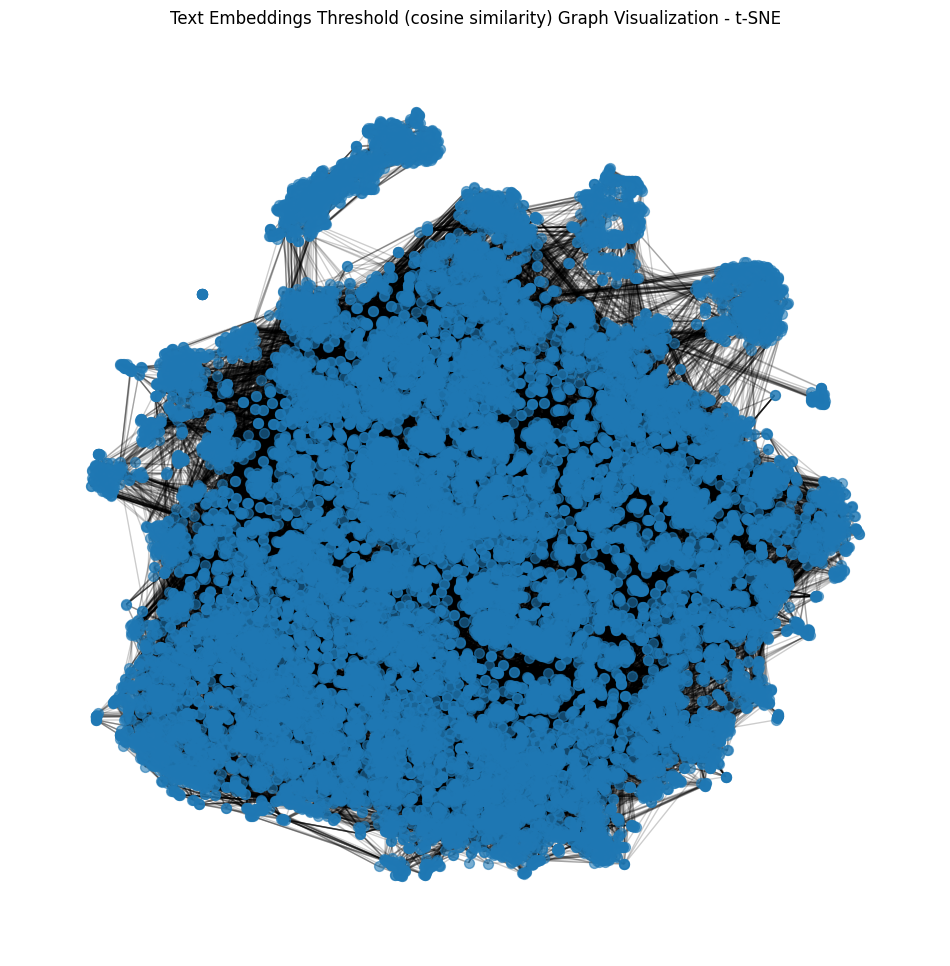

In [12]:
create_graph_visualization(tsne_coords, embeddings, 't-SNE')

In [13]:
similarity_matrix = cosine_similarity(embeddings)
similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


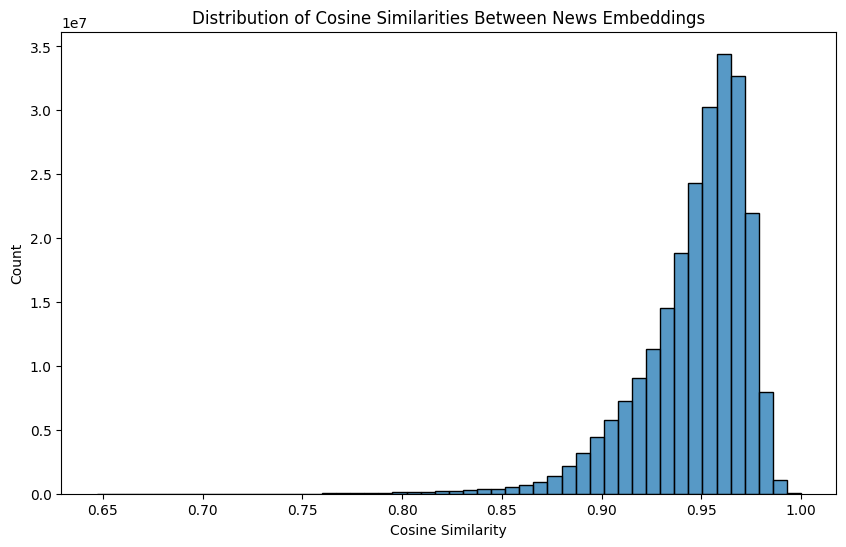

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(similarities, bins=50)
plt.title('Distribution of Cosine Similarities Between News Embeddings')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

In [16]:
import zipfile
import os
from pathlib import Path

def unzip_data(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# if not os.path.exists('ticker_data'):
    # unzip_data('ticker_data.zip', '.')

In [17]:
ticker = pl.read_csv("/kaggle/input/news-sentiment-aware-stock-market-forecasting/ticker_data/ticker_data/ABIO.csv")
print(ticker.head())

shape: (5, 9)
┌─────┬───────┬───────┬───────┬───┬─────────┬────────┬─────────────────────┬─────────────────────┐
│     ┆ open  ┆ close ┆ high  ┆ … ┆ value   ┆ volume ┆ begin               ┆ end                 │
│ --- ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---     ┆ ---    ┆ ---                 ┆ ---                 │
│ i64 ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64     ┆ f64    ┆ str                 ┆ str                 │
╞═════╪═══════╪═══════╪═══════╪═══╪═════════╪════════╪═════════════════════╪═════════════════════╡
│ 0   ┆ 13.37 ┆ 13.04 ┆ 13.37 ┆ … ┆ 6568.0  ┆ 500.0  ┆ 2020-01-03 10:00:00 ┆ 2020-01-03 10:33:05 │
│ 1   ┆ 13.03 ┆ 13.03 ┆ 13.03 ┆ … ┆ 1303.0  ┆ 100.0  ┆ 2020-01-03 11:00:00 ┆ 2020-01-03 11:25:14 │
│ 2   ┆ 13.0  ┆ 13.0  ┆ 13.0  ┆ … ┆ 24700.0 ┆ 1900.0 ┆ 2020-01-03 12:00:00 ┆ 2020-01-03 12:38:26 │
│ 3   ┆ 13.25 ┆ 13.2  ┆ 13.25 ┆ … ┆ 7925.0  ┆ 600.0  ┆ 2020-01-03 13:00:00 ┆ 2020-01-03 13:11:27 │
│ 4   ┆ 13.2  ┆ 13.2  ┆ 13.2  ┆ … ┆ 3960.0  ┆ 300.0  ┆ 2020-01-03 14:00:00 ┆ 2020-01-03 14:03:3

In [73]:
from tqdm.notebook import tqdm

def create_ticker_embeddings(path):
    ticker_files = list(Path(path).glob('*.csv'))
    ticker_embeddings = {}
    
    for file_path in tqdm(ticker_files):
        if "all_stocks" in str(file_path): 
            continue

        ticker_name = file_path.stem
        try:
            df = pl.read_csv(file_path)
            
            df = df.with_columns([
                pl.col('close').pct_change().alias('price_change'),
                pl.col('volume').pct_change().alias('volume_change')
            ])
            
            df = df.fill_null(0)
            
            features = [
                df['price_change'].mean(),
                df['price_change'].std(),
                df['price_change'].skew(),
                df['price_change'].kurtosis(),
                df['price_change'].median(),
                # df['price_change'].rolling_kurtosis(3),
                # df['price_change'].rolling_kurtosis(5),
                # df['price_change'].rolling_kurtosis(12),
                df['price_change'].rolling_median(3).mean(),
                df['price_change'].rolling_median(5).mean(),
                df['price_change'].rolling_median(12).mean(),
                df['volume_change'].mean(),
                df['volume_change'].std(),
                df['volume_change'].skew(),
                df['volume_change'].kurtosis(),
                df['volume_change'].median(),
                # df['volume_change'].rolling_kurtosis(3),
                # df['volume_change'].rolling_kurtosis(5),
                # df['volume_change'].rolling_kurtosis(12),
                df['volume_change'].rolling_median(3).mean(),
                df['volume_change'].rolling_median(5).mean(),
                df['volume_change'].rolling_median(12).mean(),
            ]
            
            ticker_embeddings[ticker_name] = np.array(features, dtype=np.float32)
            
        except Exception as e:
            print(f"Error processing {ticker_name}: {str(e)}")
            continue
    
    return ticker_embeddings

In [74]:
path = "/kaggle/input/news-sentiment-aware-stock-market-forecasting/ticker_data/ticker_data"

ticker_embeddings = create_ticker_embeddings(path)

  0%|          | 0/214 [00:00<?, ?it/s]

In [75]:
ticker_names = list(ticker_embeddings.keys())
embeddings = np.array([ticker_embeddings[name] for name in ticker_names], dtype=np.float32)
faiss.normalize_L2(embeddings)

In [76]:
def create_graph_visualization(coords, embeddings, ticker_names, title, threshold=0.8):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(embeddings)
    
    k = 50
    similarities, indices = index.search(embeddings, k)
    
    G = nx.Graph()
    
    for i, name in enumerate(ticker_names):
        G.add_node(name, pos=(coords[i, 0], coords[i, 1]))
    
    for i, name in enumerate(ticker_names):
        for j, sim in zip(indices[i], similarities[i]):
            if i != j and sim > threshold:
                G.add_edge(name, ticker_names[j], weight=float(sim))
    
    plt.figure(figsize=(15, 15))
    pos = nx.get_node_attributes(G, 'pos')
    
    nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.6)
    
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.2)
    
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(f'Ticker Embedding Threshold (cosine similarity) Graph Visualization - {title}')
    plt.axis('off')
    plt.show()


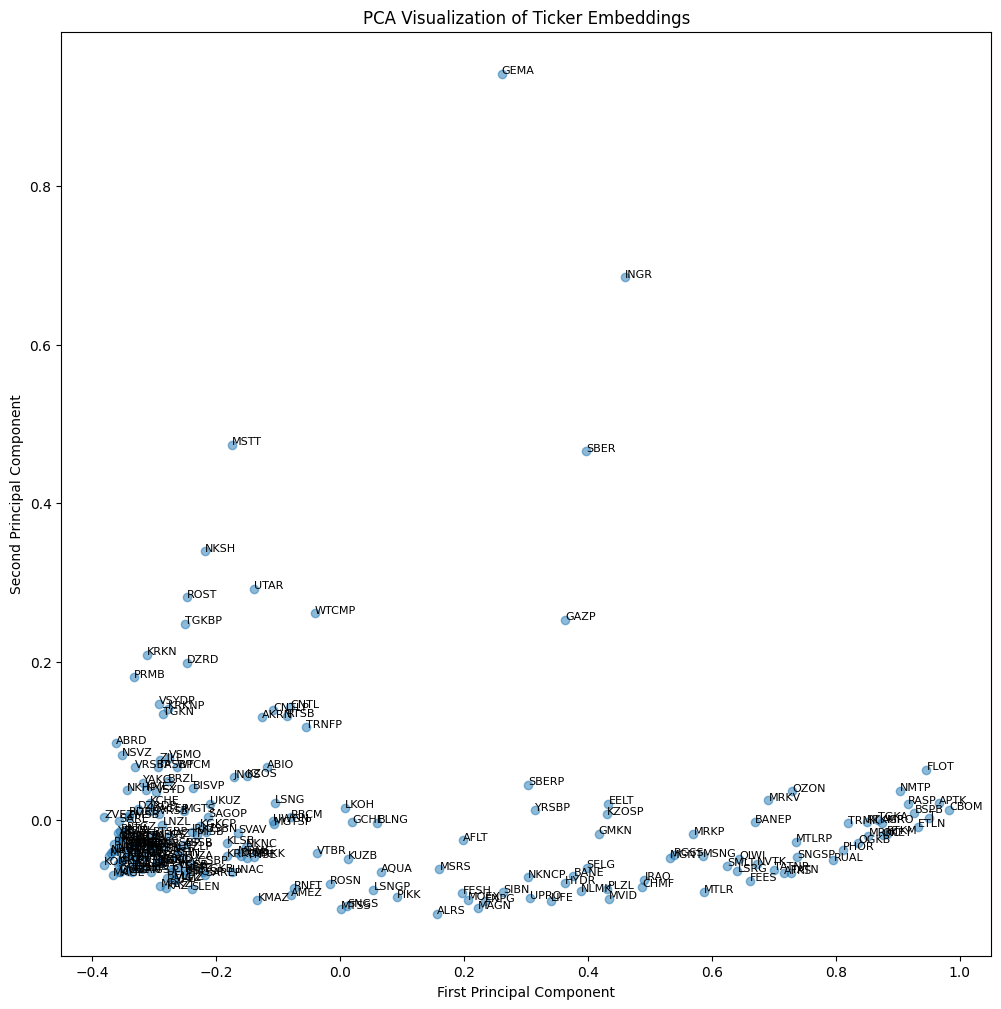

In [77]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 12))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.5)
for i, name in enumerate(ticker_names):
    plt.annotate(name, (pca_coords[i, 0], pca_coords[i, 1]), fontsize=8)
plt.title('PCA Visualization of Ticker Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

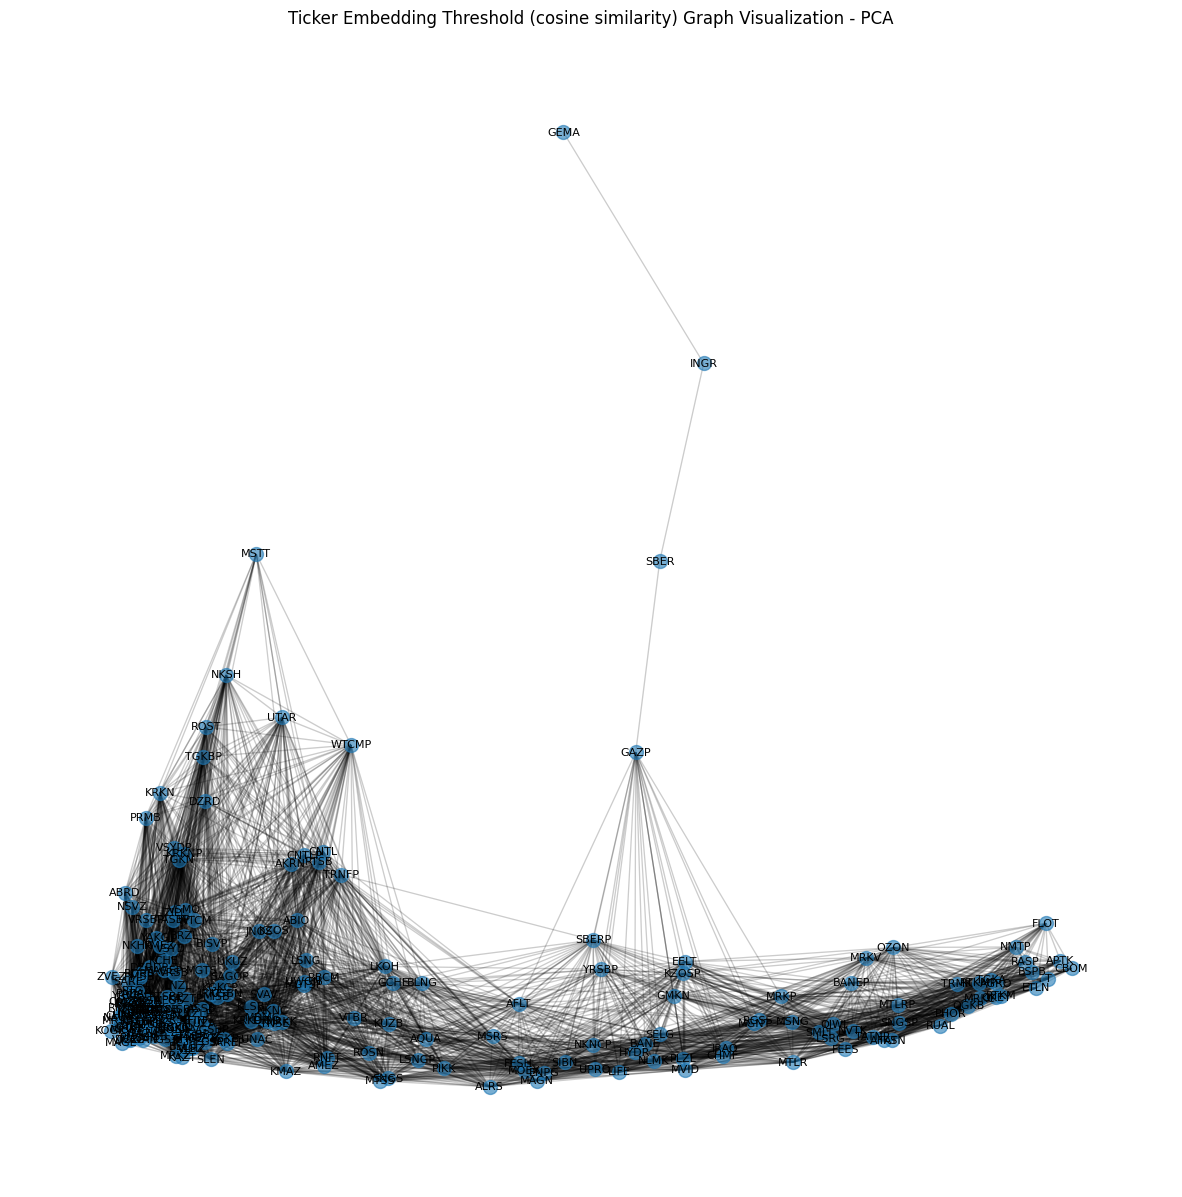

In [78]:
create_graph_visualization(pca_coords, embeddings, ticker_names, 'PCA', threshold=0.93)

In [79]:
tsne = TSNE(n_components=2, random_state=42)
tsne_coords = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 12))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], alpha=0.5)
for i, name in enumerate(ticker_names):
    plt.annotate(name, (tsne_coords[i, 0], tsne_coords[i, 1]), fontsize=8)
plt.title('t-SNE Visualization of Ticker Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

SyntaxError: unterminated string literal (detected at line 10) (3539796342.py, line 10)

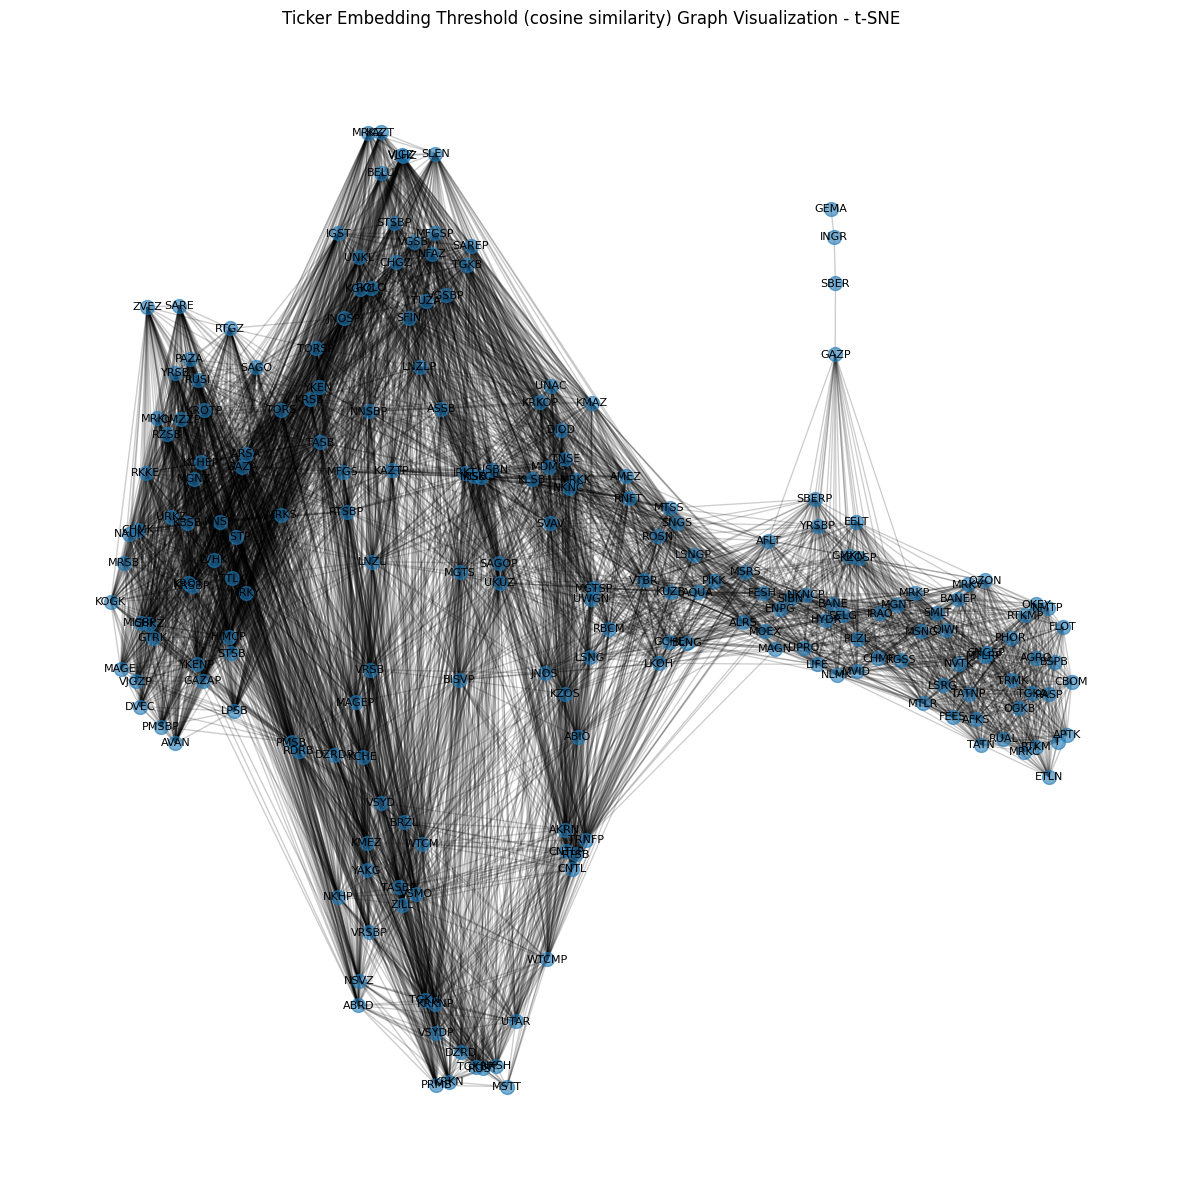

In [80]:
create_graph_visualization(tsne_coords, embeddings, ticker_names, 't-SNE', threshold=0.93)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


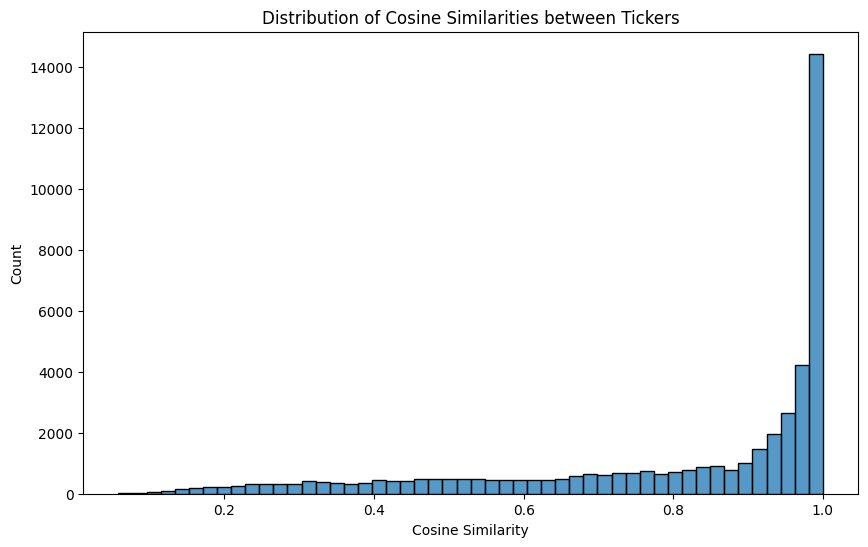

In [81]:
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
k = embeddings.shape[0]
similarities, _ = index.search(embeddings, k)
similarities = similarities[:, 1:]
similarities = similarities.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(similarities, bins=50)
plt.title('Distribution of Cosine Similarities between Tickers')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

In [82]:
def create_time_window_embeddings(ticker_data, window_size=12):
    if isinstance(ticker_data['begin'][0], str):
        ticker_data = ticker_data.with_columns(
            pl.col('begin').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S')
        )
    
    ticker_data = ticker_data.sort('begin')
    
    ticker_data = ticker_data.with_columns([
        pl.col('close').pct_change().alias('price_change'),
        pl.col('volume').pct_change().alias('volume_change')
    ])
    
    ticker_data = ticker_data.fill_null(0)
    
    embeddings = []
    timestamps = []
    
    for i in tqdm(range(window_size, len(ticker_data))):
        df = ticker_data.slice(i-window_size, window_size)
        
        features = [
            df['price_change'].mean(),
            df['price_change'].std(),
            df['price_change'].skew(),
            df['price_change'].kurtosis(),
            df['price_change'].median(),
            # df['price_change'].rolling_kurtosis(int(window_size / 4)).mean(),
            # df['price_change'].rolling_kurtosis(int(window_size / 2)).mean(),
            # df['price_change'].rolling_kurtosis(window_size).mean(),
            df['price_change'].rolling_median(int(window_size / 4)).mean(),
            df['price_change'].rolling_median(int(window_size / 2)).mean(),
            df['price_change'].rolling_median(window_size).mean(),
            df['volume_change'].mean(),
            df['volume_change'].std(),
            df['volume_change'].skew(),
            df['volume_change'].kurtosis(),
            df['volume_change'].median(),
            # df['volume_change'].rolling_kurtosis(int(window_size / 4)).mean(),
            # df['volume_change'].rolling_kurtosis(int(window_size / 2)).mean(),
            # df['volume_change'].rolling_kurtosis(window_size).mean(),
            df['volume_change'].rolling_median(int(window_size / 4)).mean(),
            df['volume_change'].rolling_median(int(window_size / 2)).mean(),
            df['volume_change'].rolling_median(window_size).mean(),
        ]
        
        embeddings.append(features)
        timestamps.append(df['begin'][-1])
    
    return np.array(embeddings, dtype=np.float32), timestamps

In [84]:
ticker_name = 'SBER'
ticker_data = pl.read_csv(f'/kaggle/input/news-sentiment-aware-stock-market-forecasting/ticker_data/ticker_data/{ticker_name}.csv')
embeddings, timestamps = create_time_window_embeddings(ticker_data)

  0%|          | 0/3148 [00:00<?, ?it/s]

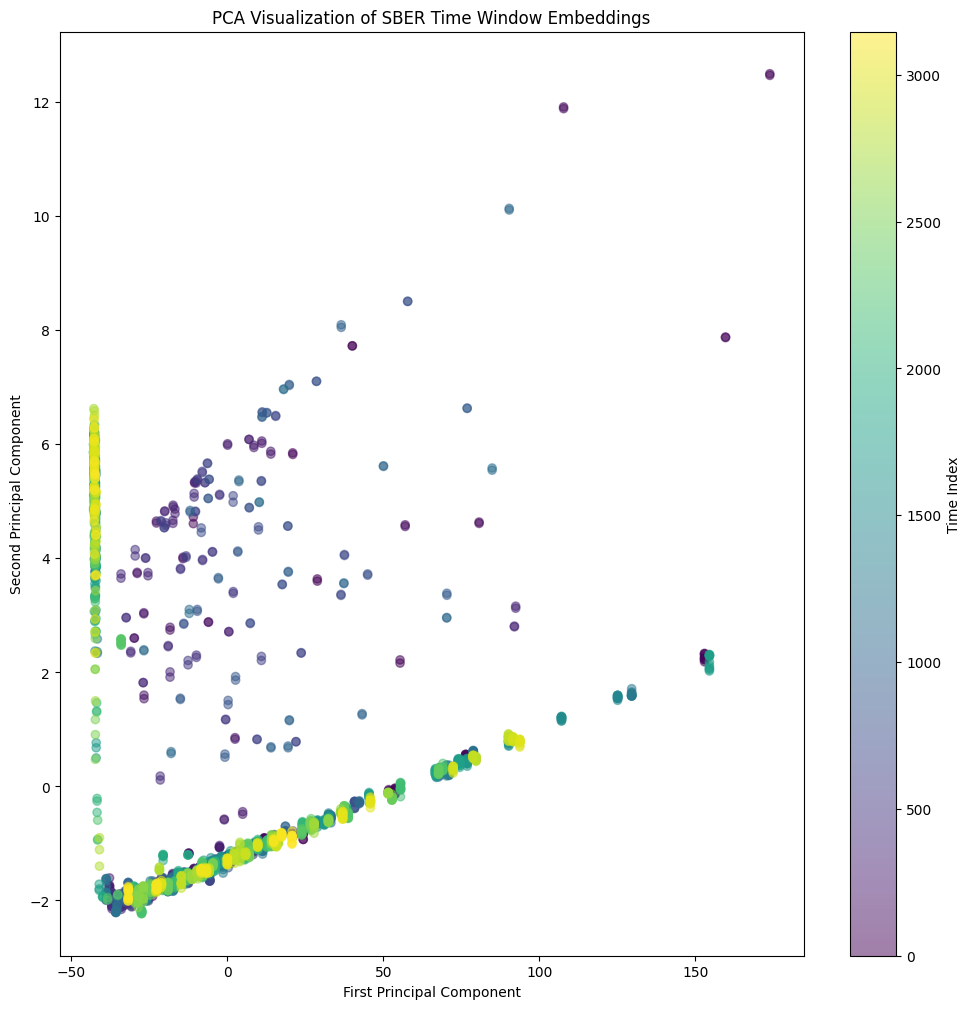

In [86]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 12))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.5, c=range(len(pca_coords)), cmap='viridis')
plt.colorbar(label='Time Index')
plt.title(f'PCA Visualization of {ticker_name} Time Window Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

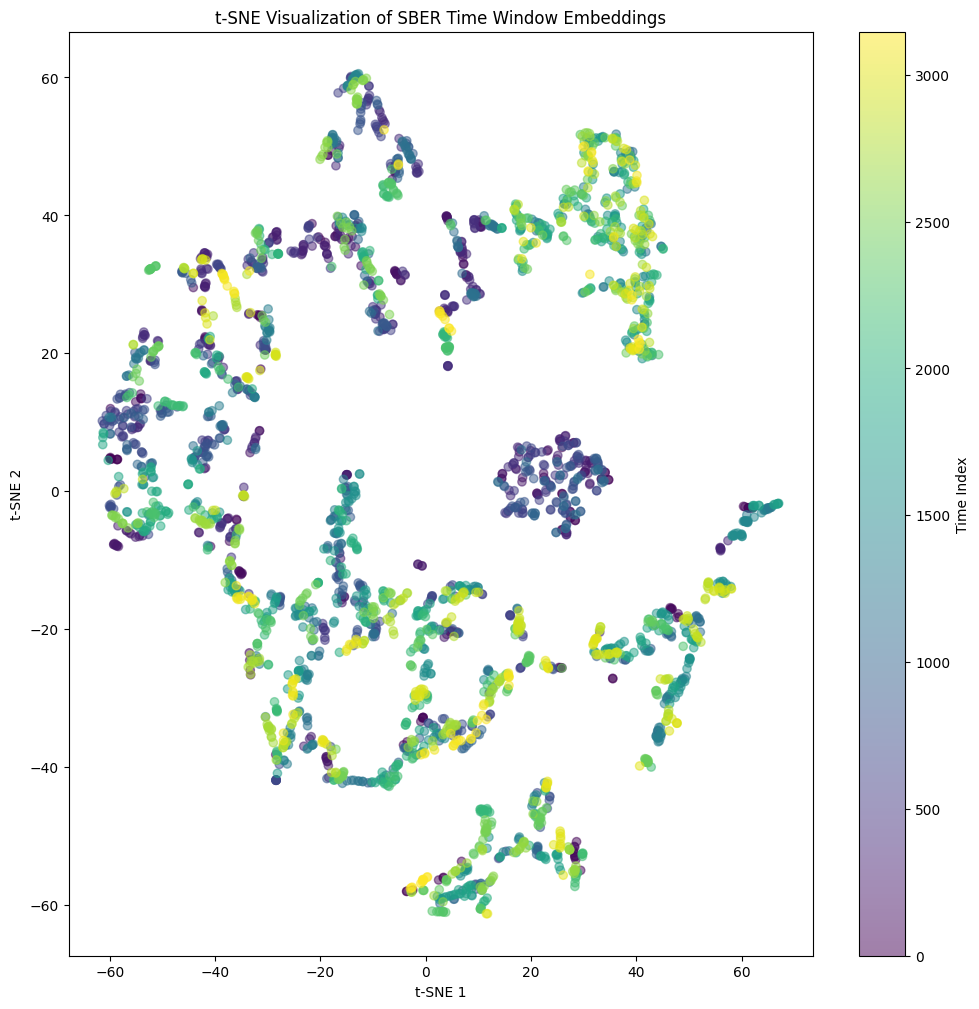

In [88]:
tsne = TSNE(n_components=2, random_state=42)
tsne_coords = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 12))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], alpha=0.5, c=range(len(tsne_coords)), cmap='viridis')
plt.colorbar(label='Time Index')
plt.title(f't-SNE Visualization of {ticker_name} Time Window Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [128]:
from datetime import datetime, timedelta

def parse_timestamp(ts_str):
    try:
        return datetime.strptime(ts_str, "%H:%M, %d %B %Y")
    except ValueError:
        try:
            return datetime.fromtimestamp(int(ts_str))
        except ValueError:
            return None

def load_and_prepare_data(timestamp, window_size=24):
    news_df = pl.read_parquet('/kaggle/input/news-sentiment-aware-stock-market-forecasting/russian_news_embeddings.parquet')
    
    news_df = news_df.with_columns([
        pl.col('timestamp').map_elements(parse_timestamp).alias('parsed_timestamp')
    ])
    
    window_start = timestamp - timedelta(hours=window_size)
    window_news = news_df.filter(
        (pl.col('parsed_timestamp') >= window_start) & 
        (pl.col('parsed_timestamp') <= timestamp)
    )
    
    ticker_files = list(Path('/kaggle/input/news-sentiment-aware-stock-market-forecasting/ticker_data/ticker_data').glob('*.csv'))
    ticker_data = {}
    
    for file_path in ticker_files:
        if "all_stocks" in str(file_path):
            continue

        ticker_name = file_path.stem
        try:
            df = pl.read_csv(file_path)
            df = df.with_columns(
                pl.col('begin').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S')
            )
            
            window_data = df.filter(
                (pl.col('begin') >= window_start) & 
                (pl.col('begin') <= timestamp + timedelta(hours=window_size))
            )
            
            if len(window_data) > 0:
                ticker_data[ticker_name] = window_data
                
        except Exception as e:
            print(f"Error processing {ticker_name}: {str(e)}")
            continue
    
    return window_news, ticker_data

In [129]:
def create_ticker_embedding(ticker_data, window_size):
    ticker_data = ticker_data.with_columns([
        pl.col('close').pct_change().alias('price_change'),
        pl.col('volume').pct_change().alias('volume_change')
    ])
    
    df = ticker_data.fill_null(0)
    
    features = [
            df['price_change'].mean(),
            df['price_change'].std(),
            df['price_change'].skew(),
            df['price_change'].kurtosis(),
            df['price_change'].median(),
            # df['price_change'].rolling_kurtosis(int(window_size / 4)).mean(),
            # df['price_change'].rolling_kurtosis(int(window_size / 2)).mean(),
            # df['price_change'].rolling_kurtosis(window_size).mean(),
            df['price_change'].rolling_median(int(window_size / 4)).mean(),
            df['price_change'].rolling_median(int(window_size / 2)).mean(),
            df['price_change'].rolling_median(window_size).mean(),
            df['volume_change'].mean(),
            df['volume_change'].std(),
            df['volume_change'].skew(),
            df['volume_change'].kurtosis(),
            df['volume_change'].median(),
            # df['volume_change'].rolling_kurtosis(int(window_size / 4)).mean(),
            # df['volume_change'].rolling_kurtosis(int(window_size / 2)).mean(),
            # df['volume_change'].rolling_kurtosis(window_size).mean(),
            df['volume_change'].rolling_median(int(window_size / 4)).mean(),
            df['volume_change'].rolling_median(int(window_size / 2)).mean(),
            df['volume_change'].rolling_median(window_size).mean(),
    ]
    
    return np.array(features, dtype=np.float32)

def calculate_price_change(ticker_data, window_size):
    next_window_data = ticker_data.filter(
        pl.col('begin') > ticker_data['begin'].max() - timedelta(hours=window_size)
    )
    
    if len(next_window_data) < 2:
        return 0
    
    first_price = next_window_data['close'][0]
    last_price = next_window_data['close'][-1]
    
    return (last_price - first_price) / first_price

In [172]:
def create_bipartite_graph(timestamp, window_size=24, price_change_threshold=0.01, similarity_threshold=0.8):
    window_news, ticker_data = load_and_prepare_data(timestamp, window_size)
    
    news_embeddings = np.array(window_news['embedding'].to_list(), dtype=np.float32)
    faiss.normalize_L2(news_embeddings)
    
    ticker_embeddings = {}
    price_changes = {}
    for ticker_name, data in ticker_data.items():
        ticker_embeddings[ticker_name] = create_ticker_embedding(data, window_size)
        price_changes[ticker_name] = calculate_price_change(data, window_size)
    
    ticker_names = list(ticker_embeddings.keys())
    ticker_embeddings_array = np.array([ticker_embeddings[name] for name in ticker_names], dtype=np.float32)
    faiss.normalize_L2(ticker_embeddings_array)
    
    G = nx.Graph()
    
    for i in range(len(news_embeddings)):
        G.add_node(f"news_{i}", type='news', embedding=news_embeddings[i])
    
    for i, name in enumerate(ticker_names):
        G.add_node(f"ticker_{name}", type='ticker', embedding=ticker_embeddings[name])
    
    news_index = faiss.IndexFlatIP(news_embeddings.shape[1])
    news_index.add(news_embeddings)
    
    ticker_index = faiss.IndexFlatIP(ticker_embeddings_array.shape[1])
    ticker_index.add(ticker_embeddings_array)
    
    k = 100
    news_similarities, news_indices = news_index.search(news_embeddings, k)
    for i in range(len(news_embeddings)):
        for j, sim in zip(news_indices[i], news_similarities[i]):
            if i != j and sim > similarity_threshold:
                G.add_edge(f"news_{i}", f"news_{j}", weight=float(sim), type='news')
    
    ticker_similarities, ticker_indices = ticker_index.search(ticker_embeddings_array, k)
    for i in range(len(ticker_embeddings_array)):
        for j, sim in zip(ticker_indices[i], ticker_similarities[i]):
            if i != j and sim > similarity_threshold:
                G.add_edge(f"ticker_{ticker_names[i]}", f"ticker_{ticker_names[j]}", 
                          weight=float(sim), type='ticker')
    
    for i in range(len(news_embeddings)):
        for j, name in enumerate(ticker_names):
            price_change = price_changes[name]
            if abs(price_change) > price_change_threshold:
                G.add_edge(f"news_{i}", f"ticker_{name}", 
                          weight=abs(price_change),
                          type='cross',
                          color='green' if price_change > 0 else 'red')
    
    return G

def visualize_bipartite_graph_mixed(G, timestamp, window_size):
    plt.figure(figsize=(20, 20))
    
    news_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'news']
    ticker_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'ticker']
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    nx.draw_networkx_nodes(G, pos, nodelist=news_nodes, node_color='blue', 
                          node_size=100, alpha=0.6, label='News')
    
    nx.draw_networkx_nodes(G, pos, nodelist=ticker_nodes, node_color='grey', 
                          node_size=100, alpha=0.6, label='Tickers')
    
    news_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'news']
    ticker_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'ticker']
    cross_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'cross']
    
    nx.draw_networkx_edges(G, pos, edgelist=news_edges, alpha=0.4, width=1.0)
    
    nx.draw_networkx_edges(G, pos, edgelist=ticker_edges, alpha=0.4, width=1.0)
    
    for u, v in cross_edges:
        edge_data = G[u][v]
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                              edge_color=edge_data['color'],
                              alpha=0.8,
                              width=0.3)
    
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(f'Bipartite Graph of News and Tickers\nTimestamp: {timestamp}\nWindow Size: {window_size}h')
    plt.legend()
    plt.axis('off')
    plt.show()

def visualize_bipartite_graph_separated(G, timestamp, window_size):
    plt.figure(figsize=(20, 20))
    
    news_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'news']
    ticker_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'ticker']
    
    pos = {}
    
    for i, node in enumerate(news_nodes):
        pos[node] = np.array([0, i / (len(news_nodes) - 1) if len(news_nodes) > 1 else 0.5])
    
    for i, node in enumerate(ticker_nodes):
        pos[node] = np.array([1, i / (len(ticker_nodes) - 1) if len(ticker_nodes) > 1 else 0.5])
    
    nx.draw_networkx_nodes(G, pos, nodelist=news_nodes, node_color='blue', 
                          node_size=100, alpha=0.6, label='News')
    
    nx.draw_networkx_nodes(G, pos, nodelist=ticker_nodes, node_color='grey', 
                          node_size=100, alpha=0.6, label='Tickers')
    
    news_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'news']
    ticker_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'ticker']
    cross_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'cross']
    
    nx.draw_networkx_edges(G, pos, edgelist=news_edges, alpha=0.4, width=1.0)
    nx.draw_networkx_edges(G, pos, edgelist=ticker_edges, alpha=0.4, width=1.0)
    
    for u, v in cross_edges:
        edge_data = G[u][v]
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                              edge_color=edge_data['color'],
                              alpha=0.8,
                              width=0.3)
    
    labels = {node: node.split('_')[-1] for node in G.nodes()}  # Simplify labels
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    
    plt.title(f'Bipartite Graph of News and Tickers\nTimestamp: {timestamp}\nWindow Size: {window_size}h')
    plt.legend()
    plt.axis('off')
    plt.show()

In [152]:
timestamp = datetime(2020, 1, 25, 12, 0)
window_size = 20
price_change_threshold = 0.01
similarity_threshold = 0.8

G = create_bipartite_graph(timestamp, window_size, price_change_threshold, similarity_threshold)

/tmp/ipykernel_35/3104684591.py:15: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  news_df = news_df.with_columns([


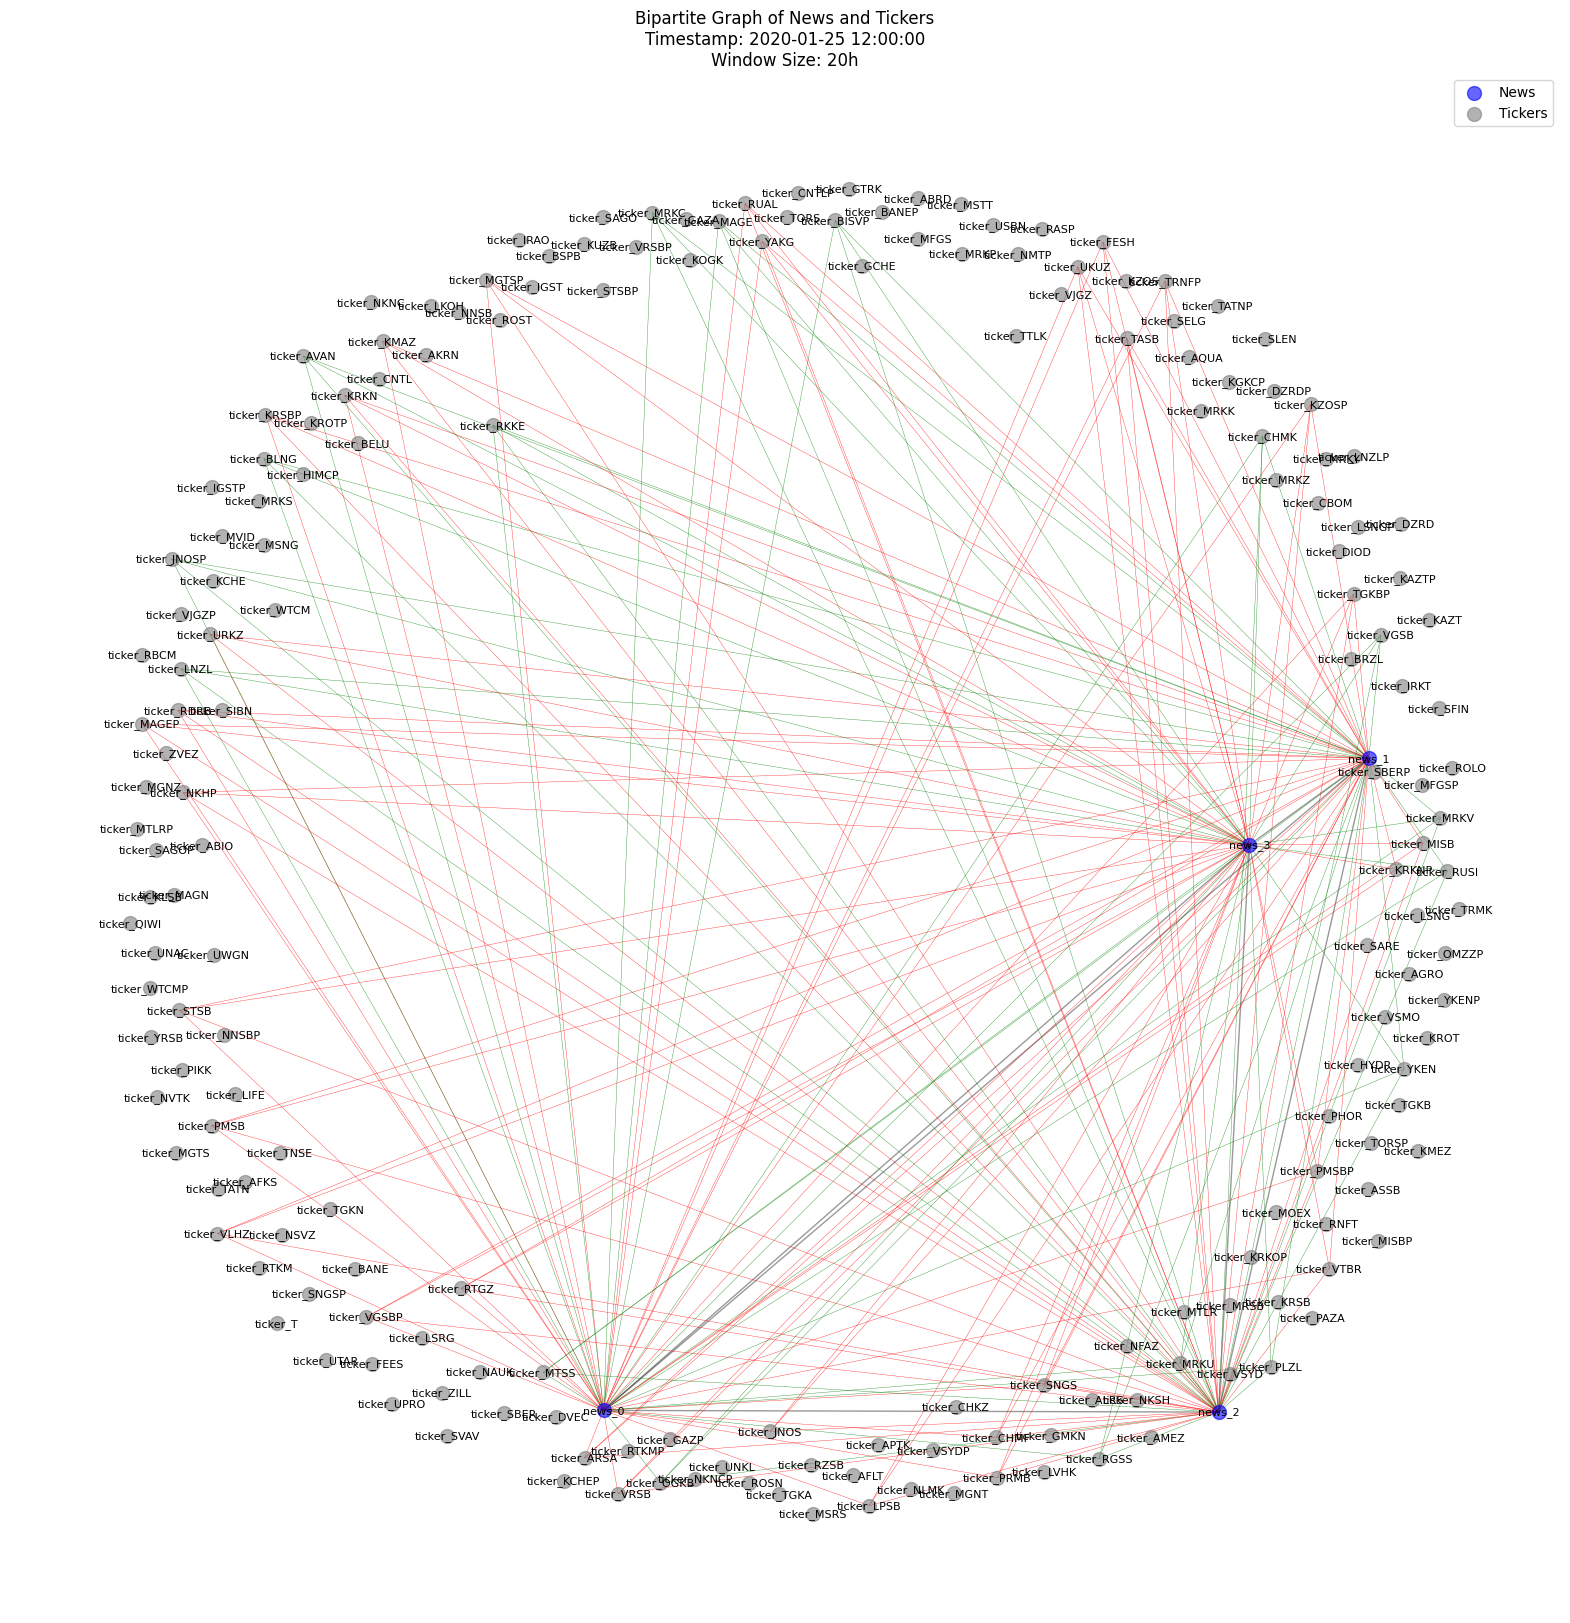

In [153]:
visualize_bipartite_graph_mixed(G, timestamp, window_size)

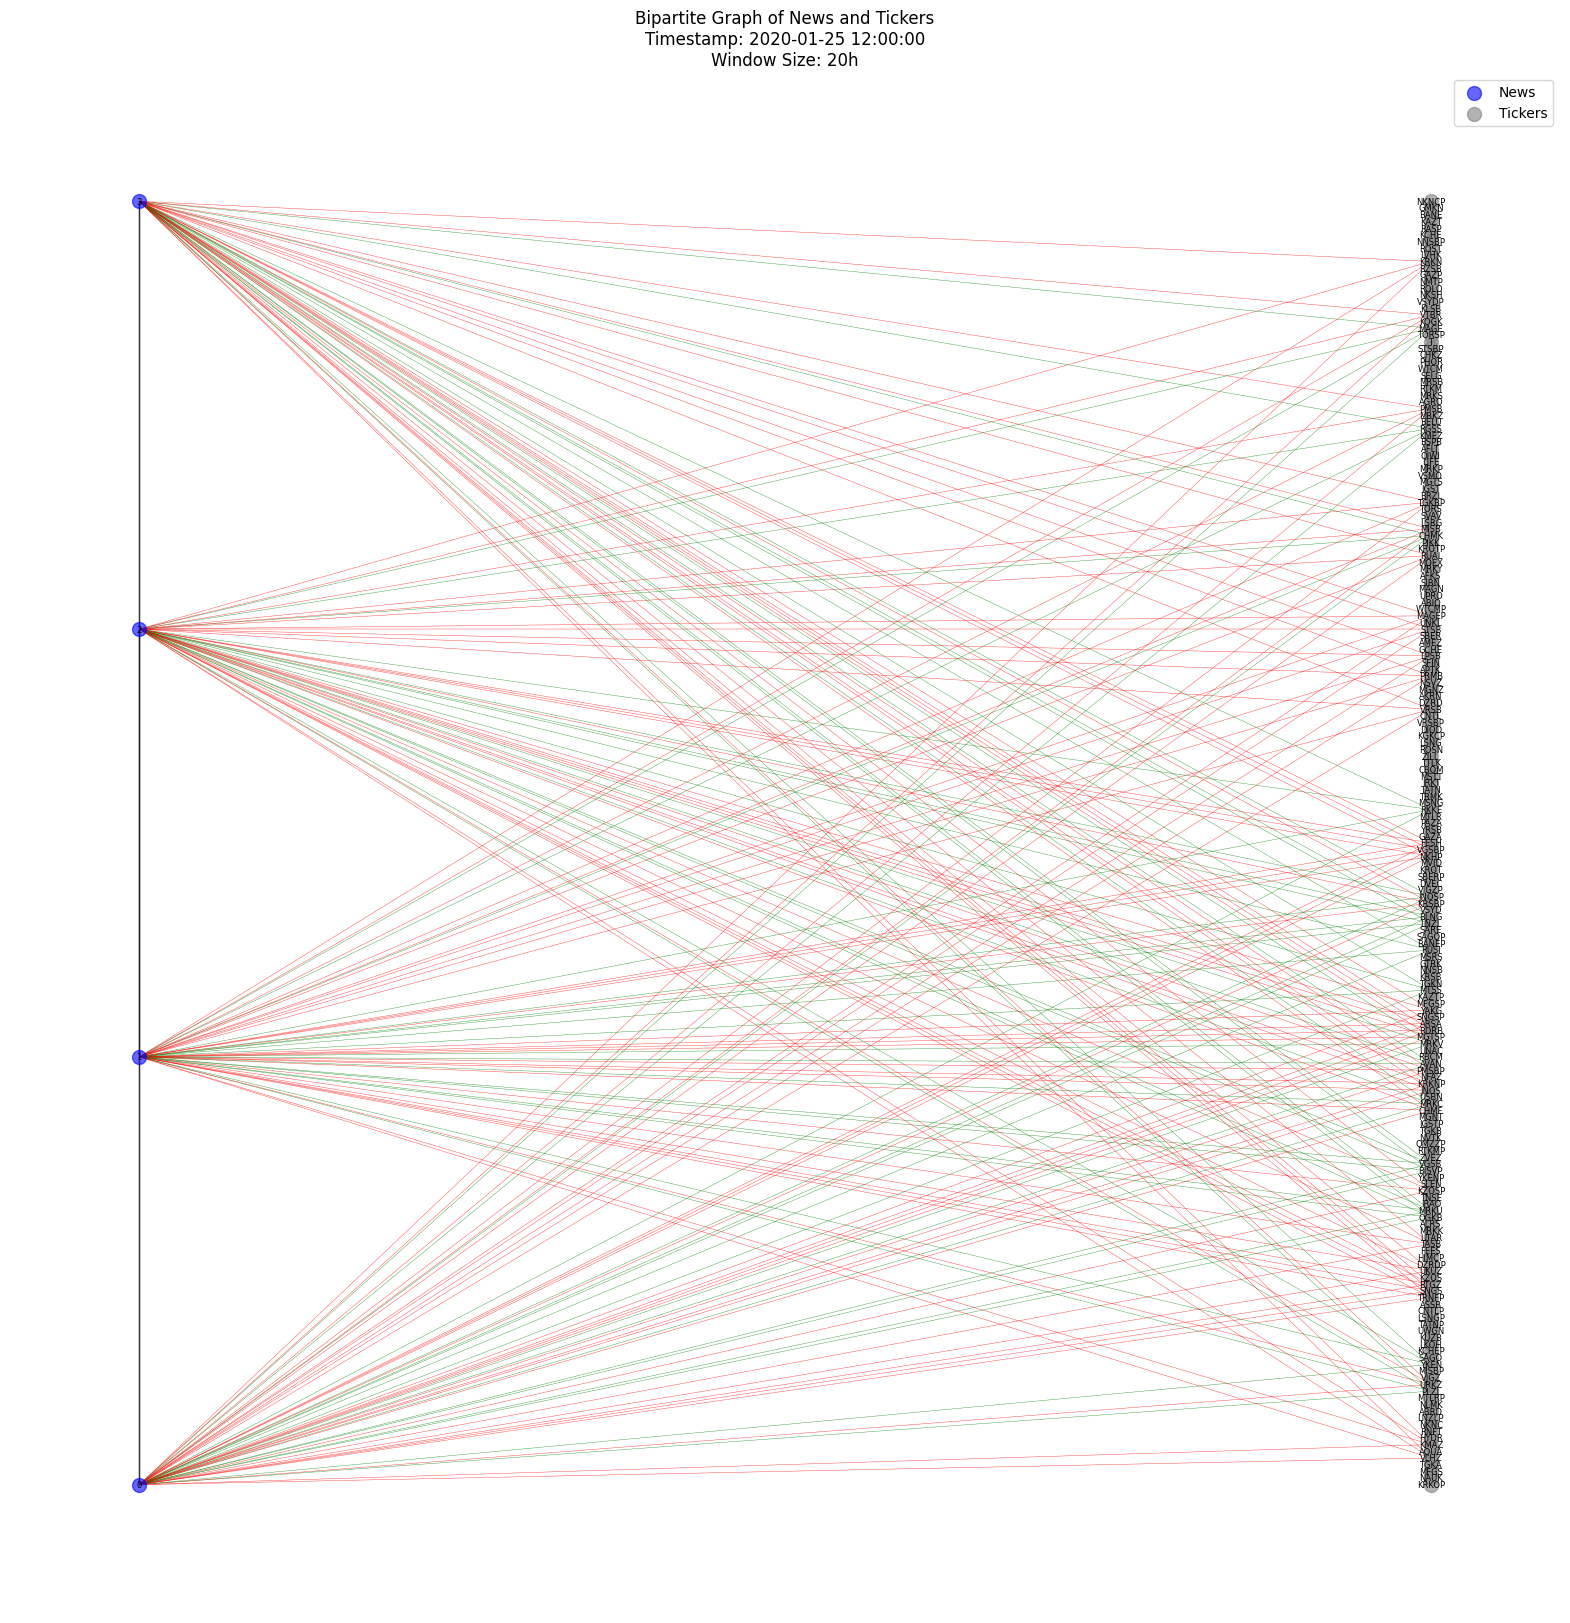

In [154]:
visualize_bipartite_graph_separated(G, timestamp, window_size)

In [175]:
import imageio
import warnings
import shutil

warnings.filterwarnings("ignore")

def dynamic_visualization_series(
    timestamp_start,
    timestamp_end,
    window_size=24, 
    price_change_threshold=0.001,
    similarity_threshold=0.8,
    fps=12,
    output_path='bipartite_animation.gif'
):    
    temp_dir = 'temp_frames'

    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

    os.makedirs(temp_dir, exist_ok=True)
    
    current_time = timestamp_start
    time_points = []
    while current_time <= timestamp_end:
        time_points.append(current_time)
        current_time += timedelta(hours=1)
    
    frame_paths = []
    for i, timestamp in enumerate(tqdm(time_points, desc="Generating frames")):
        try:
            G = create_bipartite_graph(timestamp, window_size, 
                                         price_change_threshold, similarity_threshold)
        except Exception as exc:
            continue
        
        plt.figure(figsize=(20, 20))
        
        news_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'news']
        ticker_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'ticker']
        
        pos = {}
        
        for j, node in enumerate(news_nodes):
            pos[node] = np.array([0, j / (len(news_nodes) - 1) if len(news_nodes) > 1 else 0.5])
        
        for j, node in enumerate(ticker_nodes):
            pos[node] = np.array([1, j / (len(ticker_nodes) - 1) if len(ticker_nodes) > 1 else 0.5])
        
        nx.draw_networkx_nodes(G, pos, nodelist=news_nodes, node_color='blue', 
                              node_size=100, alpha=0.6, label='News')
        
        nx.draw_networkx_nodes(G, pos, nodelist=ticker_nodes, node_color='grey', 
                              node_size=100, alpha=0.6, label='Tickers')
        
        news_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'news']
        ticker_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'ticker']
        cross_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'cross']
        
        nx.draw_networkx_edges(G, pos, edgelist=news_edges, alpha=0.4, width=1.0)
        
        nx.draw_networkx_edges(G, pos, edgelist=ticker_edges, alpha=0.4, width=1.0)
        
        for u, v in cross_edges:
            edge_data = G[u][v]
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                                  edge_color=edge_data['color'],
                                  alpha=0.8,
                                  width=0.3)
        
        labels = {node: node.split('_')[-1] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=6)
        
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        
        plt.title(f'Bipartite Graph of News and Tickers\nTimestamp: {timestamp}\nWindow Size: {window_size}h')
        plt.legend()
        plt.axis('off')
        
        frame_path = os.path.join(temp_dir, f'frame_{i:04d}.png')
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close()
        
        frame_paths.append(frame_path)
    
    print("Creating GIF...")
    with imageio.get_writer(output_path, mode='I', fps=fps) as writer:
        for frame_path in tqdm(frame_paths, desc="Writing GIF"):
            image = imageio.imread(frame_path)
            writer.append_data(image)
    
    print("Cleaning up temporary files...")
    shutil.rmtree(temp_dir)
    
    print(f"Animation saved to {output_path}")

In [176]:
timestamp_start = datetime(2020, 8, 10, 10, 0)
timestamp_end = datetime(2020, 8, 25, 18, 0)
dynamic_visualization_series(timestamp_start, timestamp_end)

Generating frames:   0%|          | 0/369 [00:00<?, ?it/s]

Creating GIF...


Writing GIF:   0%|          | 0/333 [00:00<?, ?it/s]

Cleaning up temporary files...
Animation saved to bipartite_animation.gif
